In [63]:
import pandas as pd
import io

fraud_rows = []
normal_rows = []

NORMAL_TARGET = 60000
p_normal_keep = NORMAL_TARGET / 284315

# Define column names based on the variable display
# Remove quotes and split the header string manually
header_line = '"Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"'
column_names = [name.strip('"') for name in header_line.split(',')]


data = []
# Read the file content as a single string
try:
    with open('/content/SI_L12_AUTOENCODERS_DATASET.csv', 'r', encoding='utf-8') as f:
        content = f.read()

    # Split the content into lines and process each line
    # Skip the header line
    lines = content.strip().split('\n')[1:]

    for line in lines:
        if line: # Avoid processing empty lines
            # Clean up the line: remove potential leading/trailing quotes and spaces, then split by comma
            # This regex handles commas outside of quotes
            import re
            row_data = re.split(r',', line.strip().strip('"'))
            # Further clean each item in row_data
            row_data = [item.strip().strip('"') for item in row_data]


            # Ensure the row has the correct number of columns
            if len(row_data) == len(column_names):
                data.append(row_data)
            else:
                print(f"Warning: Skipping line due to incorrect number of columns ({len(row_data)} instead of {len(column_names)}): {line}")

except FileNotFoundError:
    print("Error: The file '/content/dataset - lab 11.csv' was not found. Please check the file path.")
    data = None # Set data to None to indicate file not found
except Exception as e:
    print(f"An error occurred while reading or processing the file: {e}")
    data = None # Set data to None to indicate an error


# Convert the list of lists to a DataFrame if data was successfully read
if data:
    chunk_df = pd.DataFrame(data, columns=column_names)

    # Convert relevant columns to numeric types, coercing errors
    for col in ['Time', 'Amount', 'Class'] + [f'V{i}' for i in range(1, 29)]:
        # Ensure the column exists before attempting conversion
        if col in chunk_df.columns:
            chunk_df[col] = pd.to_numeric(chunk_df[col], errors='coerce')
        else:
            print(f"Warning: Column '{col}' not found in DataFrame after initial parsing.")

    # Drop rows where 'Class' is NaN after coercion, as they are invalid for filtering
    if 'Class' in chunk_df.columns:
        chunk_df.dropna(subset=['Class'], inplace=True)
        # Convert 'Class' to integer after dropping NaNs if appropriate
        # Use pd.Int64Dtype() to allow for potential NaN values if necessary later, though dropna should handle this
        chunk_df['Class'] = chunk_df['Class'].astype(int)

        # Filter and sample the data
        fraud_rows.append(chunk_df[chunk_df['Class'] == 1])
        # Ensure there are normal rows before sampling
        normal_df = chunk_df[chunk_df['Class'] == 0]
        if not normal_df.empty:
            normal_rows.append(normal_df.sample(frac=p_normal_keep, random_state=42))
        else:
            print("Warning: No normal class rows found for sampling.")
    else:
        print("Error: 'Class' column not found after parsing and cleaning.")

    if normal_rows or fraud_rows:
        df = pd.concat(normal_rows + fraud_rows).sample(frac=1, random_state=42).reset_index(drop=True)

        print("Dimensiones del dataset:", df.shape)
        print("Distribución de clases:\n", df['Class'].value_counts())
        display(df.head())
    else:
        print("No data processed for fraud or normal classes.")
else:
    print("Data could not be loaded or processed.")

Dimensiones del dataset: (60492, 31)
Distribución de clases:
 Class
0    60000
1      492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,40946.0,0.949651,-0.168557,0.253949,1.026223,-0.099157,0.166770,0.069750,-0.006161,-0.243838,...,0.016699,-0.247195,-0.226578,-0.516095,0.480243,-0.461846,0.008425,0.040348,150.00,0
1,31052.0,-10.930244,6.000305,-10.746348,1.319919,-4.576451,-1.194886,-2.561206,5.249172,2.739458,...,-0.828865,-1.306951,-0.838345,-1.683528,0.607446,-0.420511,-0.655371,-0.936925,89.99,0
2,49372.0,1.497429,-1.149740,0.572843,-1.520871,-1.645849,-0.444841,-1.320183,0.096800,-1.704024,...,-0.364730,-0.802357,0.154808,-0.097475,0.088312,-0.400266,0.028585,0.011062,5.00,0
3,132193.0,2.116635,0.174639,-2.036012,1.146078,0.879271,-0.569977,0.562149,-0.308889,0.385604,...,-0.032021,0.125162,-0.115920,-1.078120,0.575945,-0.421192,-0.019390,-0.075552,1.00,0
4,43971.0,-1.047812,-0.223278,1.837459,-2.393252,-1.621007,-0.934938,-0.970229,0.544069,-2.037873,...,-0.024973,0.085703,-0.224490,0.320916,0.377270,-0.162897,0.178626,0.032847,8.10,0


In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separar características y etiqueta
X = df.drop('Class', axis=1).astype('float32').values
y = df['Class'].values

# División estratificada en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
from sklearn.neural_network import MLPRegressor

# Entrenar solo con transacciones normales
X_train_normal = X_train_scaled[y_train == 0]

# Autoencoder con estructura 15-7-15
autoencoder = MLPRegressor(
    hidden_layer_sizes=(15, 7, 15),
    activation='relu',
    solver='adam',
    max_iter=30,
    random_state=42
)

autoencoder.fit(X_train_normal, X_train_normal)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(15, 7, 15), max_iter=30, random_state=42)

In [66]:
import numpy as np

# Reconstrucción y error MSE en train
train_pred = autoencoder.predict(X_train_normal)
mse_train = np.mean((X_train_normal - train_pred) ** 2, axis=1)

# Reconstrucción y error MSE en test
test_pred = autoencoder.predict(X_test_scaled)
mse_test = np.mean((X_test_scaled - test_pred) ** 2, axis=1)

# Umbral basado en percentil 99.5 del error en train
threshold = np.percentile(mse_train, 99.5)
print(f"Umbral de detección de fraude (p99.5): {threshold:.4f}")

# Predicción: 1 si el error supera el umbral
y_pred = (mse_test > threshold).astype(int)

Umbral de detección de fraude (p99.5): 3.9794


Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9973    0.9953    0.9963     12001
           1     0.5410    0.6735    0.6000        98

    accuracy                         0.9927     12099
   macro avg     0.7692    0.8344    0.7982     12099
weighted avg     0.9936    0.9927    0.9931     12099



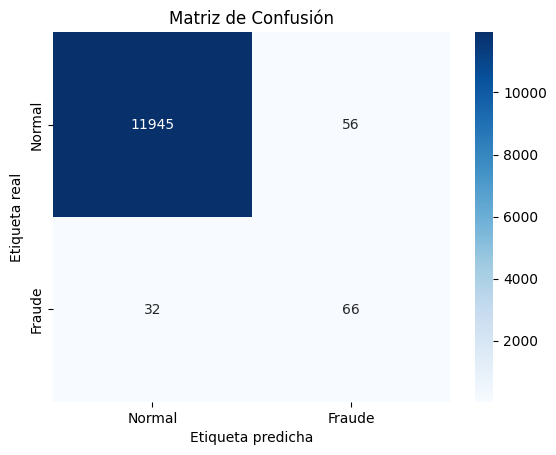

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reporte de métricas
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'])
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

¿Qué umbral de error de reconstrucción es el más adecuado para detectar fraudes sin generar demasiados falsos positivos?

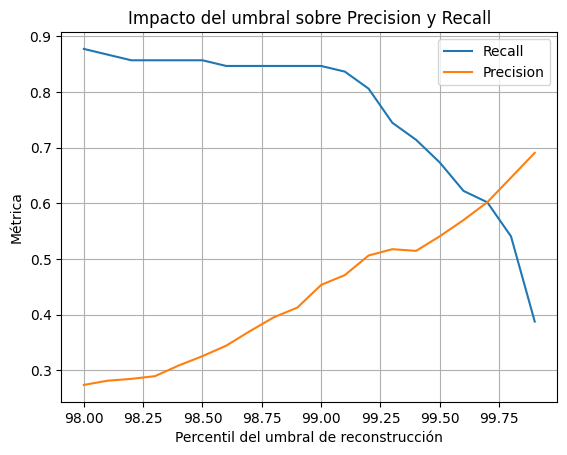

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

# Simulación de variación de umbral
percentiles = np.linspace(98, 99.9, 20)
thresholds = np.percentile(mse_train, percentiles)
recalls = []
precisions = []

for t in thresholds:
    y_pred_temp = (mse_test > t).astype(int)
    recalls.append(recall_score(y_test, y_pred_temp))
    precisions.append(precision_score(y_test, y_pred_temp))

plt.plot(percentiles, recalls, label='Recall')
plt.plot(percentiles, precisions, label='Precision')
plt.xlabel("Percentil del umbral de reconstrucción")
plt.ylabel("Métrica")
plt.title("Impacto del umbral sobre Precision y Recall")
plt.legend()
plt.grid(True)
plt.show()